# Coursera Final Capstone Project

## *Introduction/Business Problem - Description*
#### While travelling in New York, we noticed that there aren't as many Korean BBQ restaurants as other ethnic restaurants such as Itallian or Japanese in Manhattan, New York.   
#### Some of the Korean BBQ restaurants that we visited such as Jongro BBQ on 32nd Street seemed to be very busy and making a lot of profit with fully booked tables and people waiting in line for over an hour to be served.  
#### However, we barely saw Korean BBQ restaurants, if not none, in other parts of Manhattan.  We want to find the best possible location for a Korean BBQ restaurant in a location where population traffic is dense but little or no Korean restaurants are around. 
#### We also want to know locations where population traffic is dense and people gave good ratings or tips for similar food as our target audience will be not just people who would go eat at Korean BBQ but generally people who would go eat BBQ at a restaurant.  So that we can come up with different marketing strategies to attract more diverse groups of people.

## *A plan to solve the problem - Solution Architecture*
#### First, we need to find locations of all Korean BBQ restaurants and locations of restaurants that serve similar food.  This can be done using the Foursquare API and using keywords such as BBQ, meat, and etc.  
#### Second, we need to determine population traffic at these locations.  We can determine this by looking at tip counts, like counts,  other types of counts, or perhaps a weighted combination of these metrics.  We will be manipulating location data as well as venue data that include trends as well.  So we may exclude places that might be seasonal or temporarily hot.
#### Lastly, once we retrieve these data, we will utilize weighted traffic scores and average ratings to pinpoint the potential best locations for us to launch a Korean BBQ restaurant or we may use these metadata to train a model (tree, svm, or some other model) to predict a hot/cold binary class.  This will depend on the result of our model training and of utilization of those average scores.


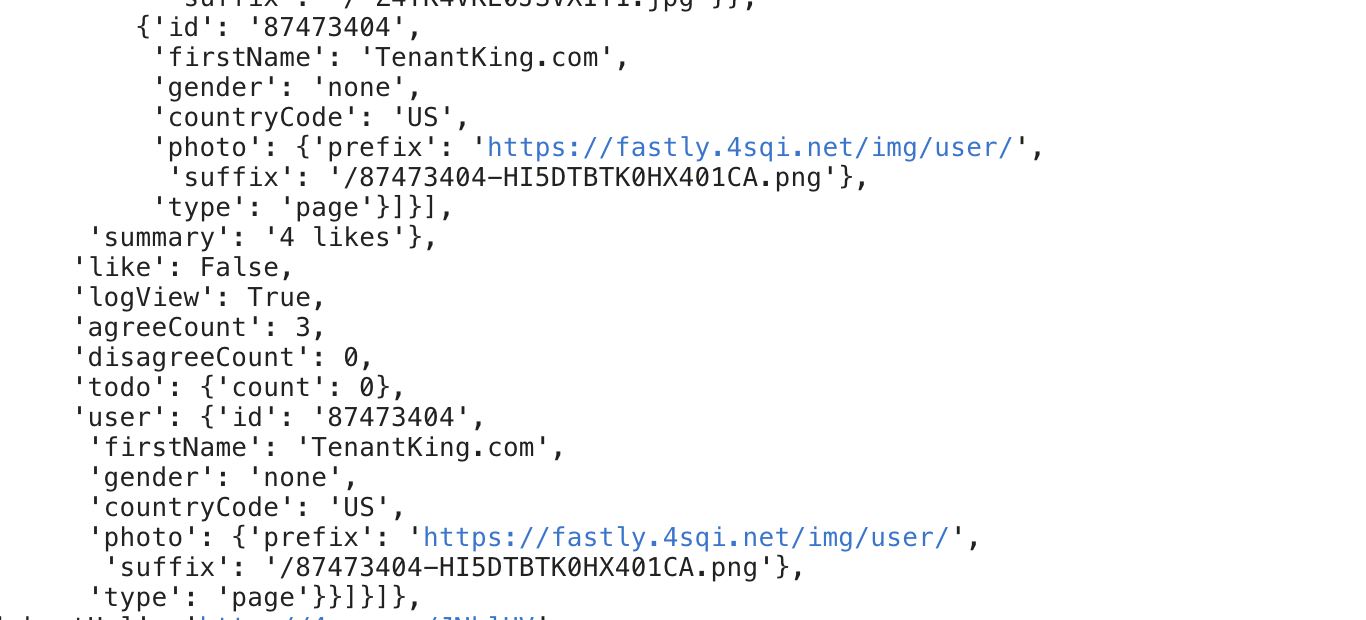

#### Location Data

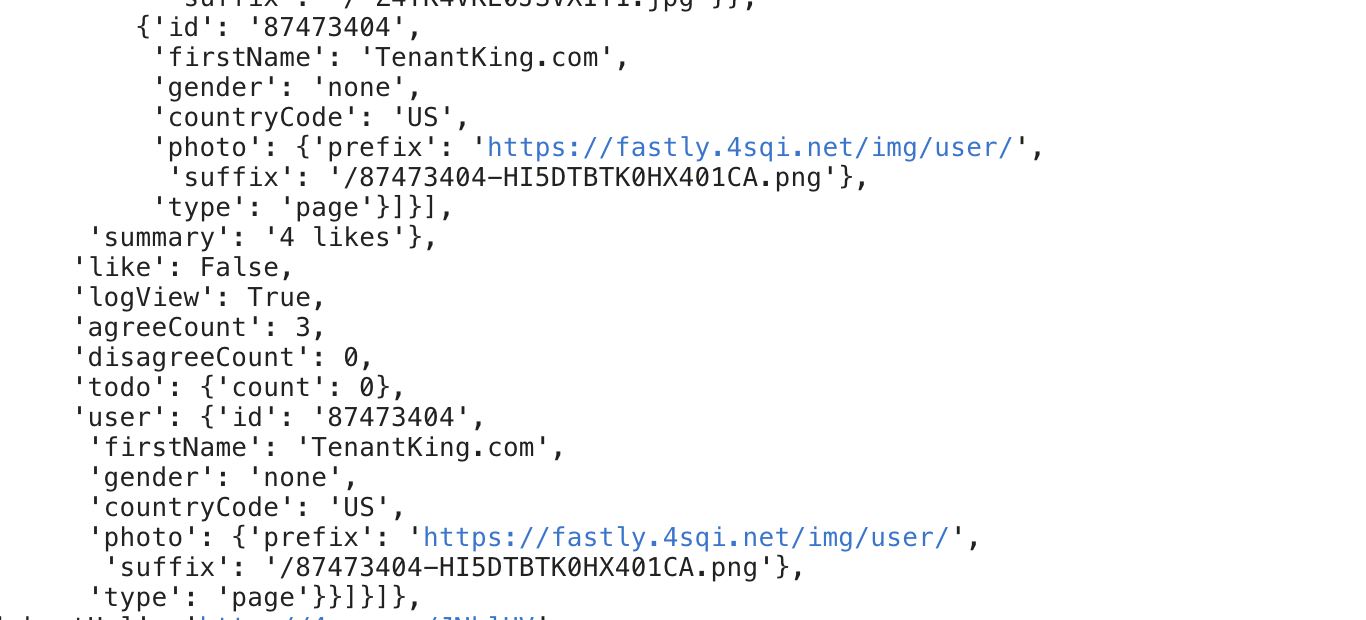

#### Venue Data